In [1]:
from pathlib import Path
import jax.numpy as jnp
import sys
sys.path.append('../')
from read_data import load_datasets
from jaxpm.painting import compensate_cic
import yaml
from read_model import read_model
from jax.experimental.ode import odeint
from jaxpm.pm import make_ode_fn
import jax_cosmo as jc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jaxpm.pm import get_delta
from jaxpm.utils import power_spectrum, cross_correlation_coefficients
import numpy as np
from loss import get_mse_pos
plt.style.use(['science', 'vibrant'])

In [2]:
# add option for time adding-diffusion like
# check feature maps and potential plots, highlight density dependence
# run halo finder -> train on 128^3 at least for 256 Mpc box?
# why is memory exploiding as function of nsims? it should only be loaded once
# hyper opt with wand
# think of model validations: run on bigger volume same resolution

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [70]:
run_name = 'elated-wood-175' #'olive-star-167' 

In [71]:
mesh_lr = 32
mesh_hr= 64
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}/")
omega_c = 0.25
sigma8 = 0.8
cosmology = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

scale_factors = jnp.load(data_dir / f"scale_factors.npy")
snapshots = None
if snapshots is not None:
    scale_factors = scale_factors[snapshots]

_, val_data = load_datasets(
        1,
        1,
        mesh_hr=64,
        mesh_lr=32,
        data_dir=data_dir,
        snapshots=snapshots,
    )
data = val_data[0]

In [72]:

model_dir = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/models/{run_name}')

with open(model_dir / 'config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)['correction_model']

neural_net, params = read_model(
    model_dir,
)

In [73]:
config

{'channels_hidden_dim': 16,
 'embed_globals': True,
 'globals_embedding_dim': 8,
 'input_dim': 2,
 'kernel_size': 3,
 'latent_size': 32,
 'n_convolutions': 3,
 'n_fully_connected': 2,
 'n_globals_embedding': 2,
 'n_knots': 16,
 'pad_periodic': True,
 'type': 'cnn'}

In [74]:
def get_prediction(
    params,
    pos_lr, 
    vel_lr,
    scale_factors,
):
    pos_pm, vel_pm = odeint(
        make_ode_fn(mesh_shape=(mesh_lr,mesh_lr,mesh_lr), 
                    add_correction=config['type'], 
                    model=neural_net),
        [pos_lr[0], vel_lr[0]],
        scale_factors,
        cosmology,
        params,
        rtol=1e-5,
        atol=1e-5,
    )
    return pos_pm, vel_pm



In [113]:
pos_pred, vel_pred = get_prediction(
    params,
    data['lr'].positions * mesh_lr,
    data['lr'].velocities * mesh_lr,
    scale_factors,

)
pos_hr = (data['hr'].positions * mesh_lr) % mesh_lr
pos_pred = pos_pred % mesh_lr

In [114]:
pos_lr_test = (data['lr'].positions * mesh_lr) % mesh_lr

In [115]:
mse_scale = [get_mse_pos(pos_hr[i], pos_lr_test[i]) for i in range(len(pos_pred))]

In [116]:
mse_scale_pred = [get_mse_pos(pos_hr[i], pos_pred[i]) for i in range(len(pos_pred))]

[Array(0.00242918, dtype=float32),
 Array(0.00447144, dtype=float32),
 Array(0.00694673, dtype=float32),
 Array(0.00984894, dtype=float32),
 Array(0.0131665, dtype=float32),
 Array(0.01688432, dtype=float32),
 Array(0.02098152, dtype=float32),
 Array(0.02542887, dtype=float32),
 Array(0.03019221, dtype=float32),
 Array(0.0352315, dtype=float32),
 Array(0.04050278, dtype=float32),
 Array(0.04595484, dtype=float32),
 Array(0.05153456, dtype=float32),
 Array(0.0571842, dtype=float32),
 Array(0.06284577, dtype=float32),
 Array(0.06845821, dtype=float32),
 Array(0.07396673, dtype=float32),
 Array(0.07932109, dtype=float32),
 Array(0.08448884, dtype=float32),
 Array(0.08944985, dtype=float32),
 Array(0.09417205, dtype=float32),
 Array(0.09864321, dtype=float32),
 Array(0.10285427, dtype=float32),
 Array(0.10681157, dtype=float32),
 Array(0.11051966, dtype=float32)]

In [117]:
mse_scale_pred

[Array(0.00242918, dtype=float32),
 Array(0.00418493, dtype=float32),
 Array(0.00580556, dtype=float32),
 Array(0.0073227, dtype=float32),
 Array(0.0087715, dtype=float32),
 Array(0.01018553, dtype=float32),
 Array(0.01159311, dtype=float32),
 Array(0.01301541, dtype=float32),
 Array(0.01446785, dtype=float32),
 Array(0.01596063, dtype=float32),
 Array(0.0174986, dtype=float32),
 Array(0.01908238, dtype=float32),
 Array(0.02070908, dtype=float32),
 Array(0.02237297, dtype=float32),
 Array(0.02406645, dtype=float32),
 Array(0.02578108, dtype=float32),
 Array(0.02750705, dtype=float32),
 Array(0.02923503, dtype=float32),
 Array(0.03095614, dtype=float32),
 Array(0.03266233, dtype=float32),
 Array(0.03434728, dtype=float32),
 Array(0.03600454, dtype=float32),
 Array(0.03762903, dtype=float32),
 Array(0.03921573, dtype=float32),
 Array(0.04076181, dtype=float32)]

In [110]:
np.array(mse_scale)/scale_factors**1.5

Array([0.07681747, 0.0876988 , 0.09489069, 0.10054282, 0.10533199,
       0.10952844, 0.11324318, 0.1165105 , 0.1193452 , 0.12174863,
       0.12372129, 0.12525368, 0.12634397, 0.12698846, 0.1271909 ,
       0.1269541 , 0.12629592, 0.12524073, 0.12383597, 0.12213624,
       0.12016933, 0.1179817 , 0.11561382, 0.11311422, 0.11051966],      dtype=float32)

In [109]:
np.mean(mse_scale)

0.053291555

In [108]:
np.mean(np.array(mse_scale)/scale_factors**1.5)

Array(0.11508071, dtype=float32)

In [63]:
import jax_cosmo.background as bkgrd 

growth = bkgrd.growth_factor(cosmology, scale_factors)


In [69]:
np.array(mse_scale) / growth**1.9

Array([0.11989983, 0.12066903, 0.11882142, 0.11689075, 0.11530392,
       0.11410122, 0.11325324, 0.1126733 , 0.11230411, 0.11211456,
       0.11206561, 0.11210109, 0.11216797, 0.11232103, 0.11245599,
       0.11254942, 0.11258533, 0.11254783, 0.11243728, 0.11225821,
       0.11198993, 0.11173432, 0.11140674, 0.11100306, 0.11051966],      dtype=float32)

In [77]:
pos_pred /= mesh_lr

Text(0.5, 1.0, 'HR')

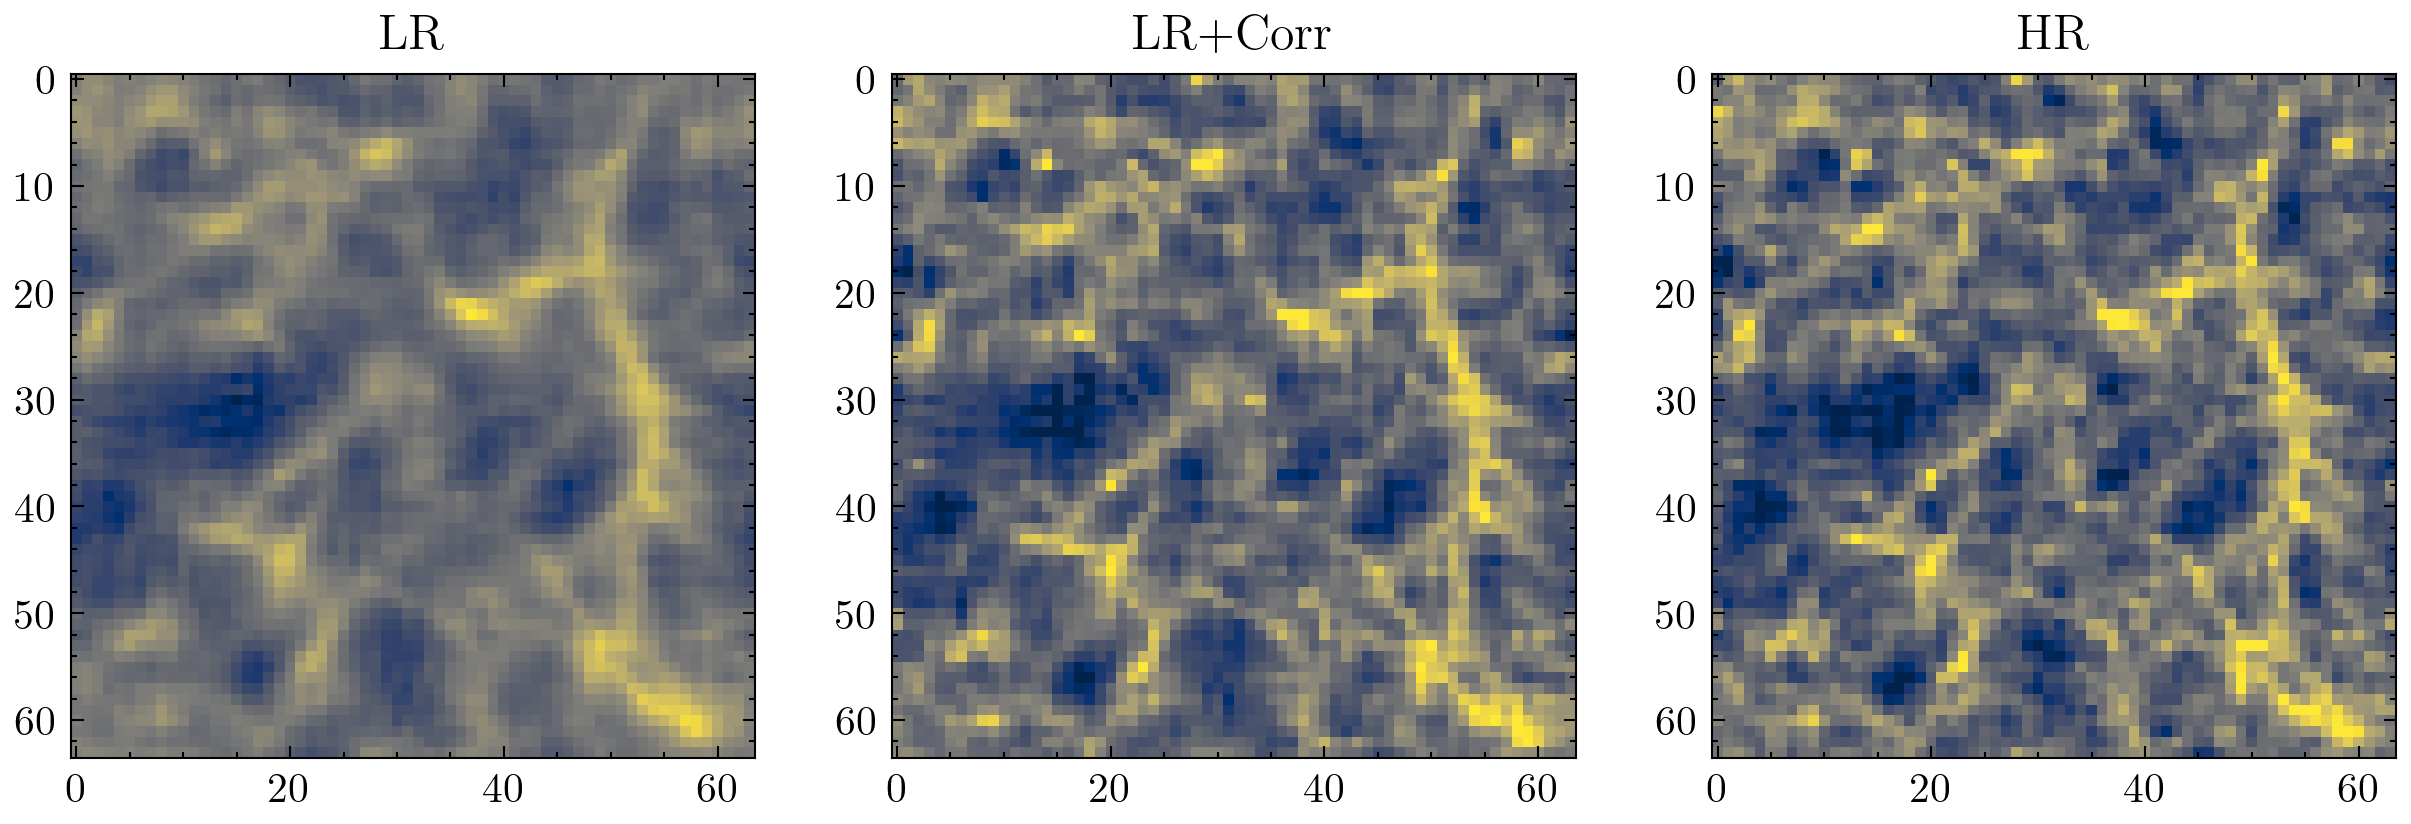

In [78]:

mesh_plot = 64
norm = LogNorm()#(vmin=0, vmax=150) 
cmap = 'cividis'

delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("LR+Corr")
ax[2].set_title("HR")

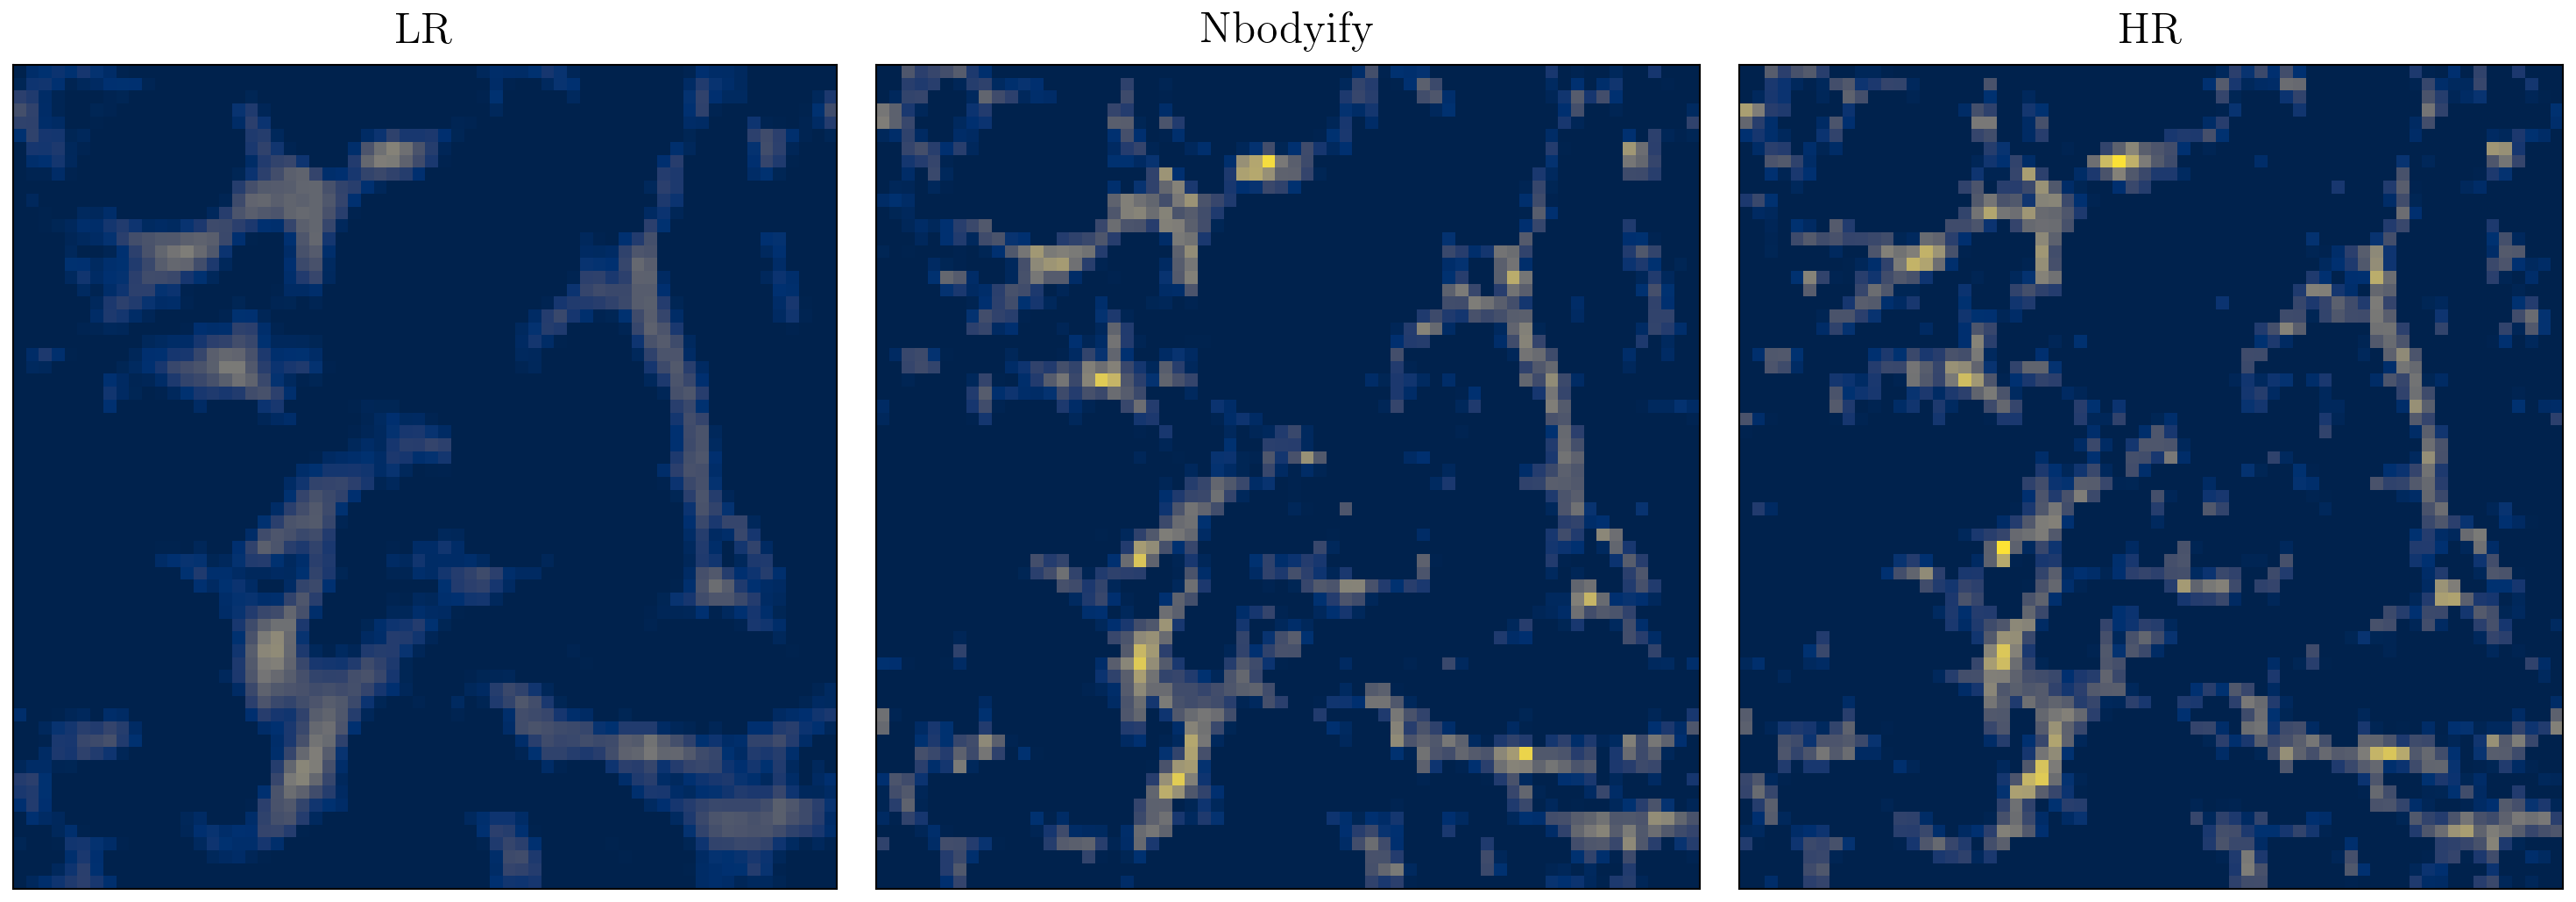

In [79]:

mesh_plot = 64



fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow((delta_lr[:30,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred[:30,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_hr[:30,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 
ax[0].set_title("LR")
ax[1].set_title("Nbodyify")
ax[2].set_title("HR")
plt.tight_layout()
plt.savefig('figures/png/densities.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/densities.pdf', bbox_inches="tight")

In [22]:
delta_hr.shape

(64, 64, 64)

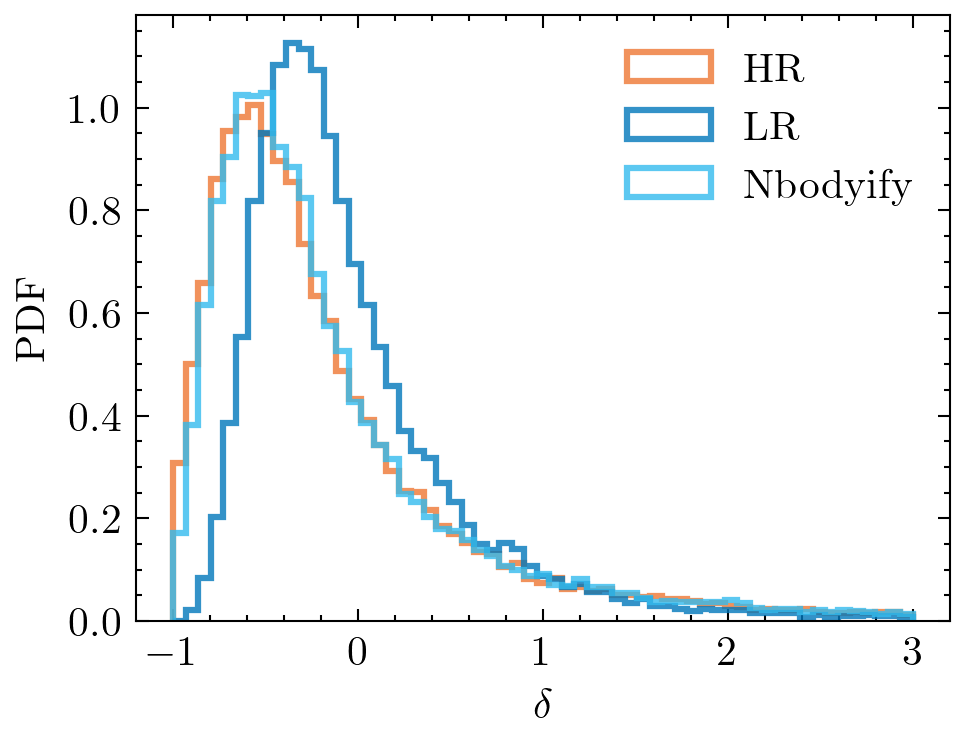

In [80]:
_ = plt.hist(delta_hr[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5)
_ = plt.hist(delta_lr[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')
plt.savefig('figures/png/density_histogram.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/density_histogram.pdf', bbox_inches="tight")

Text(0, 0.5, 'PDF')

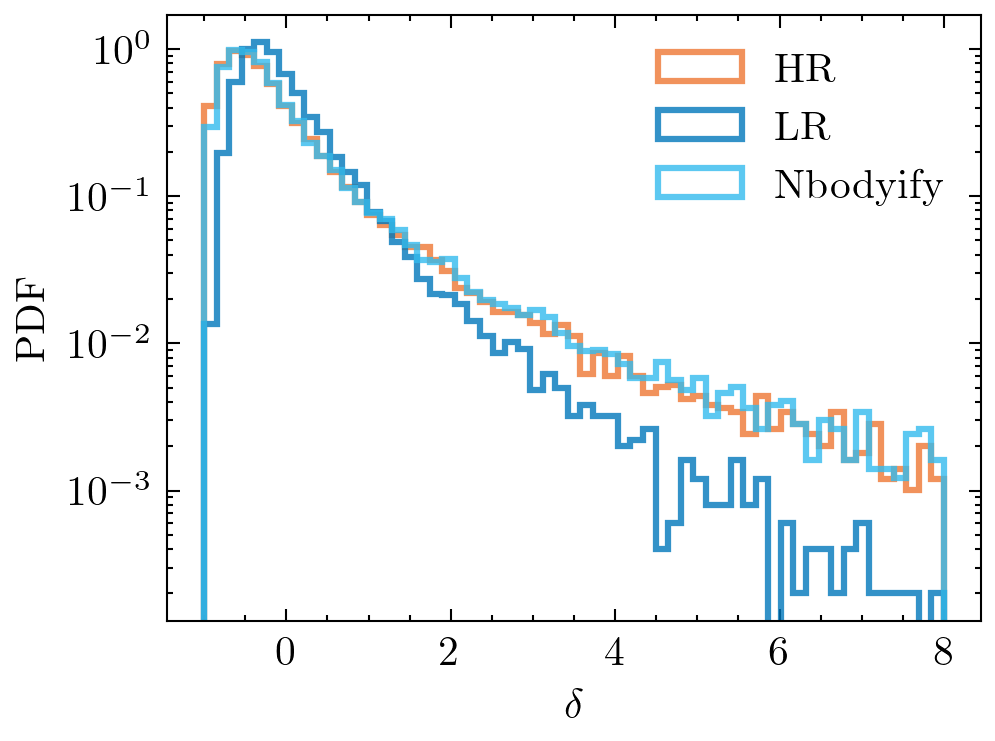

In [81]:
_ = plt.hist(delta_hr[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_lr[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5, log=True)
_ = plt.hist(delta_pred[::2,::2,::2].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5, log=True,)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')

In [82]:
k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_pred = power_spectrum(
      compensate_cic(delta_pred),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


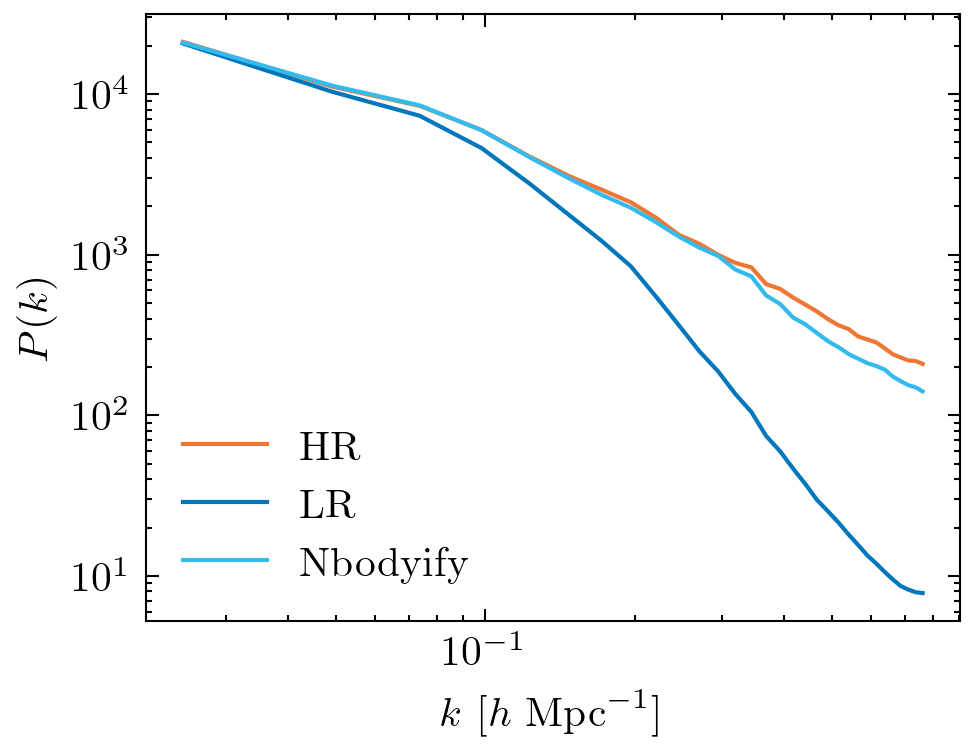

In [83]:
plt.loglog(k,pk_hr, label='HR')
c_lr = plt.loglog(k,pk_lr, label='LR')
c_pred = plt.loglog(k,pk_pred, label='Nbodyify')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.savefig('figures/png/pk_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/pk_z0.pdf', bbox_inches="tight")

Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

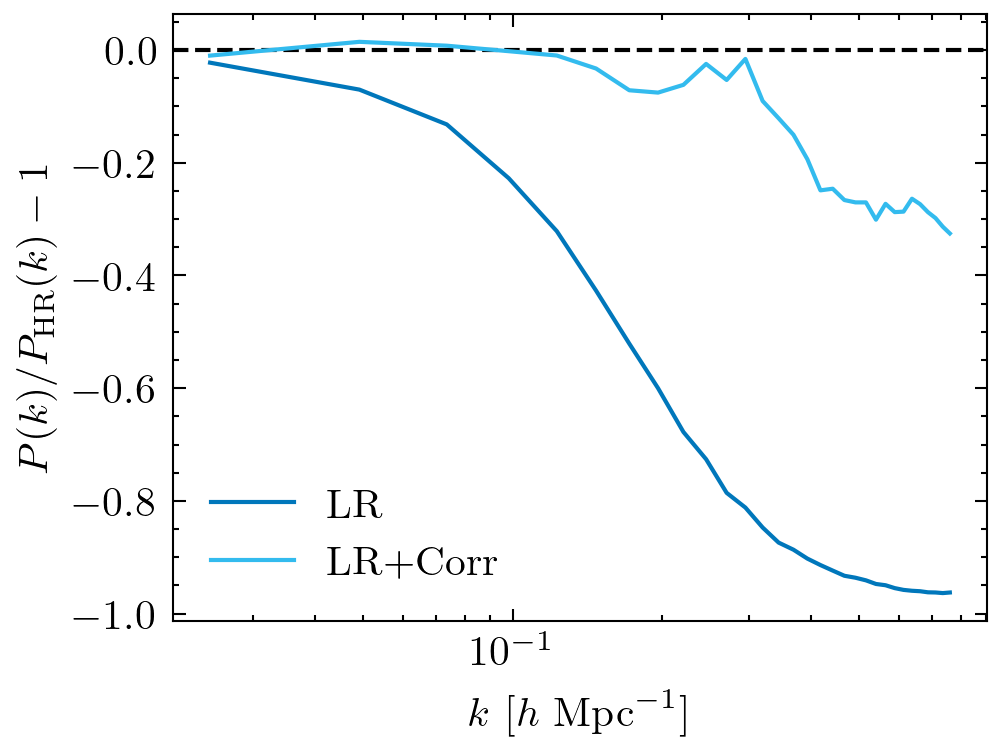

In [84]:
plt.axhline(y=0, linestyle='dashed', color='black')
plt.semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
plt.semilogx(k,pk_pred/pk_hr-1., label='LR+Corr', color=c_pred[0].get_color())

plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")

In [85]:
k, cross_hr_hr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)


k, cross_hr_lr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, cross_hr_pred = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_pred),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)



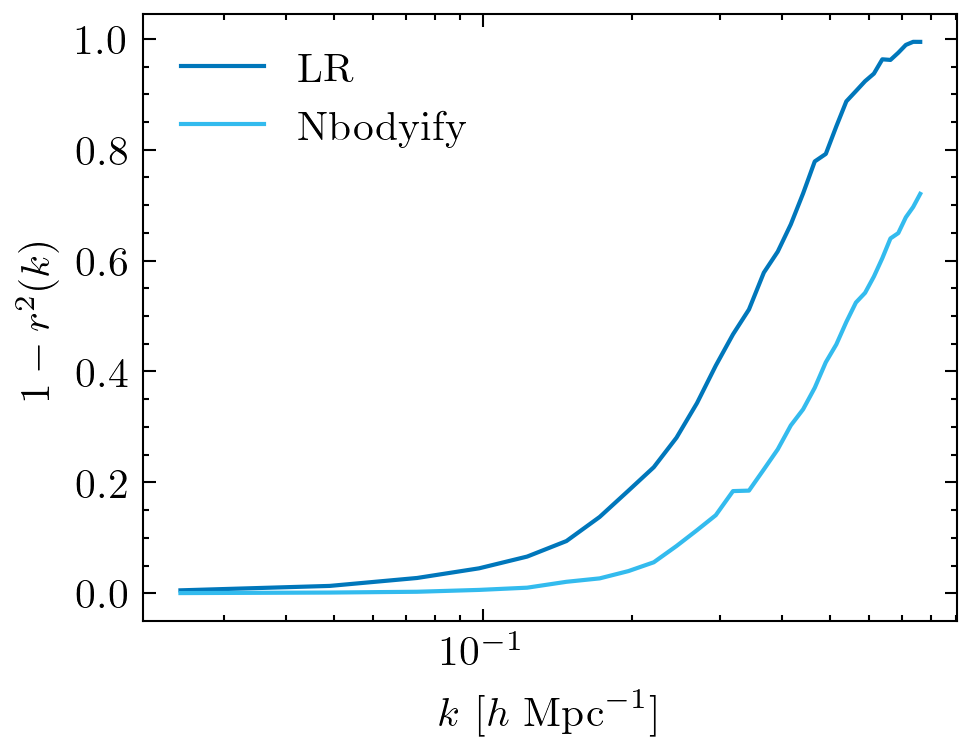

In [86]:
plt.semilogx(k, 1. - cross_hr_lr**2/pk_hr/pk_lr, label='LR', color=c_lr[0].get_color())
plt.semilogx(k, 1. - cross_hr_pred**2/pk_hr/pk_pred, label='Nbodyify', color=c_pred[0].get_color())
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$1 - r^2(k)$")
plt.legend()
plt.savefig('figures/png/r2_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/r2_z0.pdf', bbox_inches="tight")

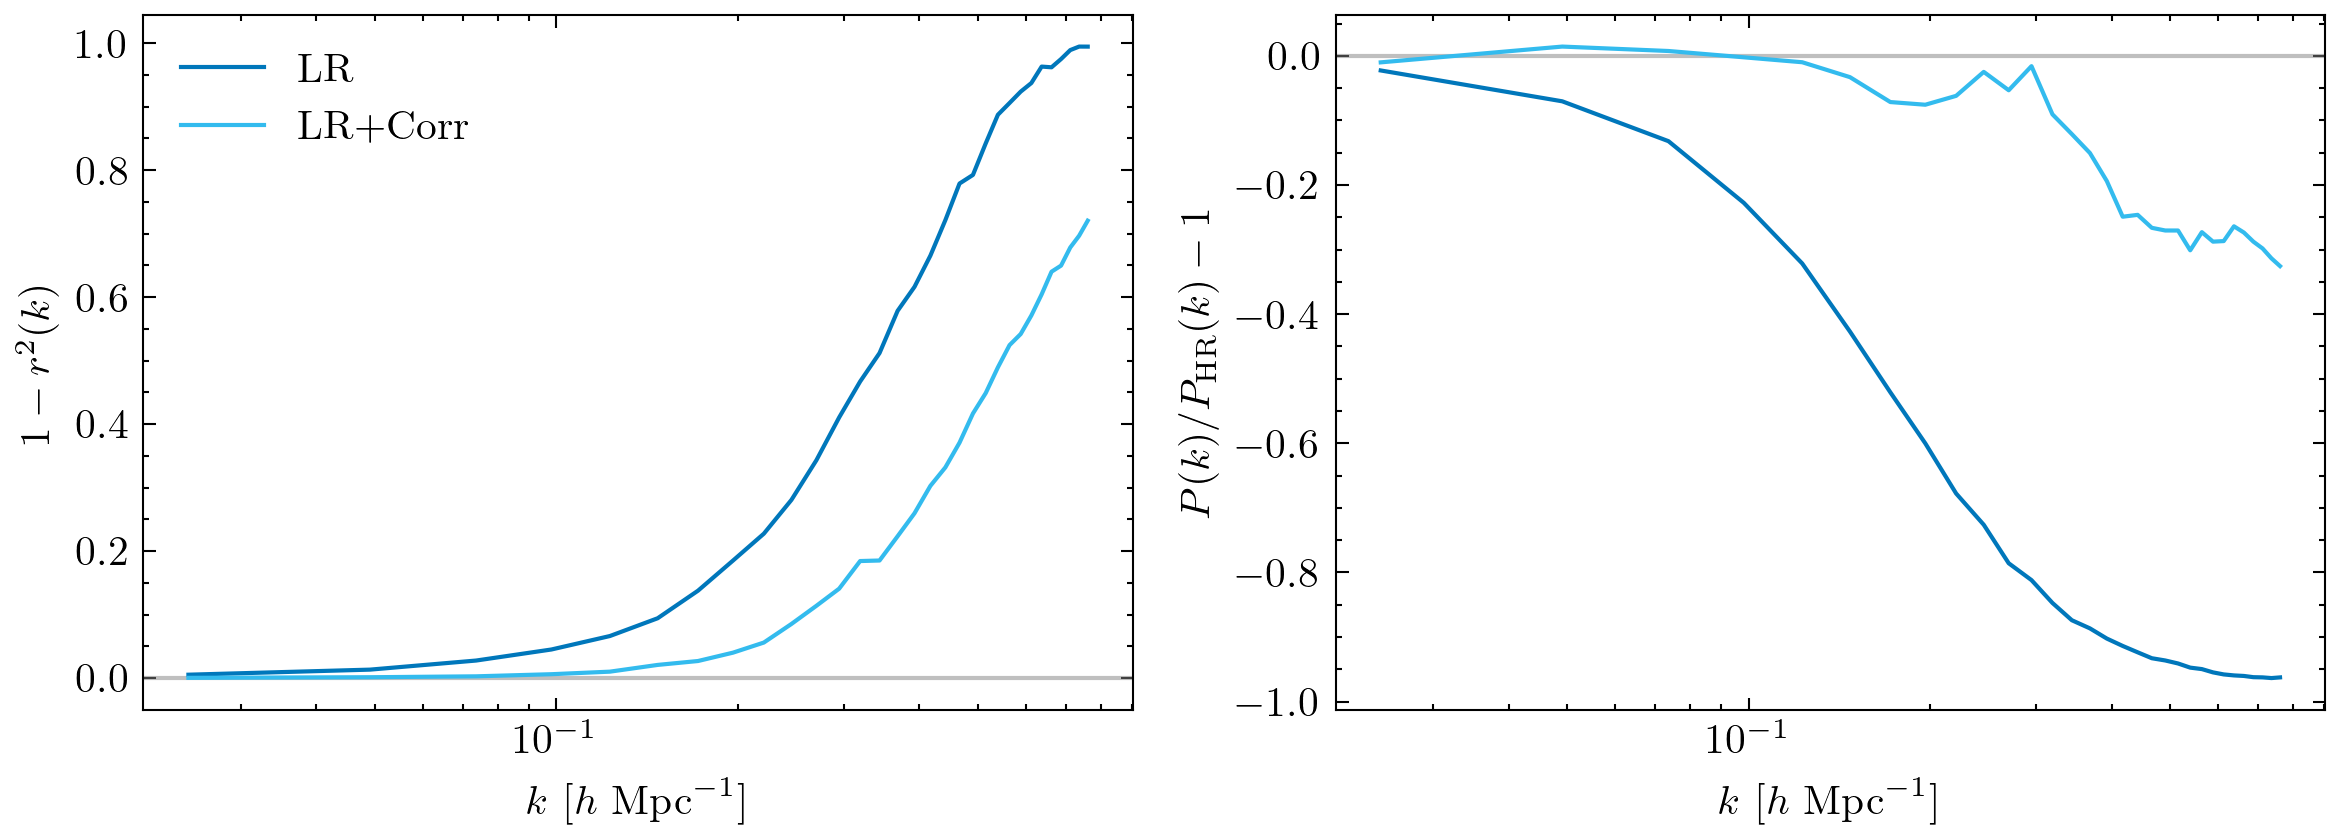

In [87]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].axhline(y=0, alpha=0.5, color='gray')
ax[1].axhline(y=0, alpha=0.5, color='gray')

ax[0].semilogx(k, 1. - cross_hr_lr**2/pk_hr/pk_lr, label='LR', color=c_lr[0].get_color())
ax[0].semilogx(k, 1. - cross_hr_pred**2/pk_hr/pk_pred, label='LR+Corr', color=c_pred[0].get_color())

ax[1].semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
ax[1].semilogx(k,pk_pred/pk_hr-1., label='LR+Corr', color=c_pred[0].get_color())

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
ax[0].legend()
plt.tight_layout()

In [88]:
pk_hrs, pk_lrs, pk_preds = [], [], []
r_lrs_sq, r_preds_sq = [], []
for i, factor in enumerate(scale_factors):
    delta_hr = get_delta(data['hr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_lr = get_delta(data['lr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_pred = get_delta(pos_pred[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    k, pk_lr = power_spectrum(
        compensate_cic(delta_lr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, pk_pred = power_spectrum(
        compensate_cic(delta_pred),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, pk_hr = power_spectrum(
        compensate_cic(delta_hr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)
    k, cross_hr_lr = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_lr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, cross_hr_pred = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_pred),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)
    pk_hrs.append(pk_hr)
    pk_lrs.append(pk_lr)
    pk_preds.append(pk_pred)
    r_lrs_sq.append(cross_hr_lr**2 / pk_hr/ pk_lr)
    r_preds_sq.append(cross_hr_pred**2 / pk_hr/ pk_pred)

In [89]:
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter



/n/home11/ccuestalazaro/tmp/ipykernel_3910582/2933318172.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

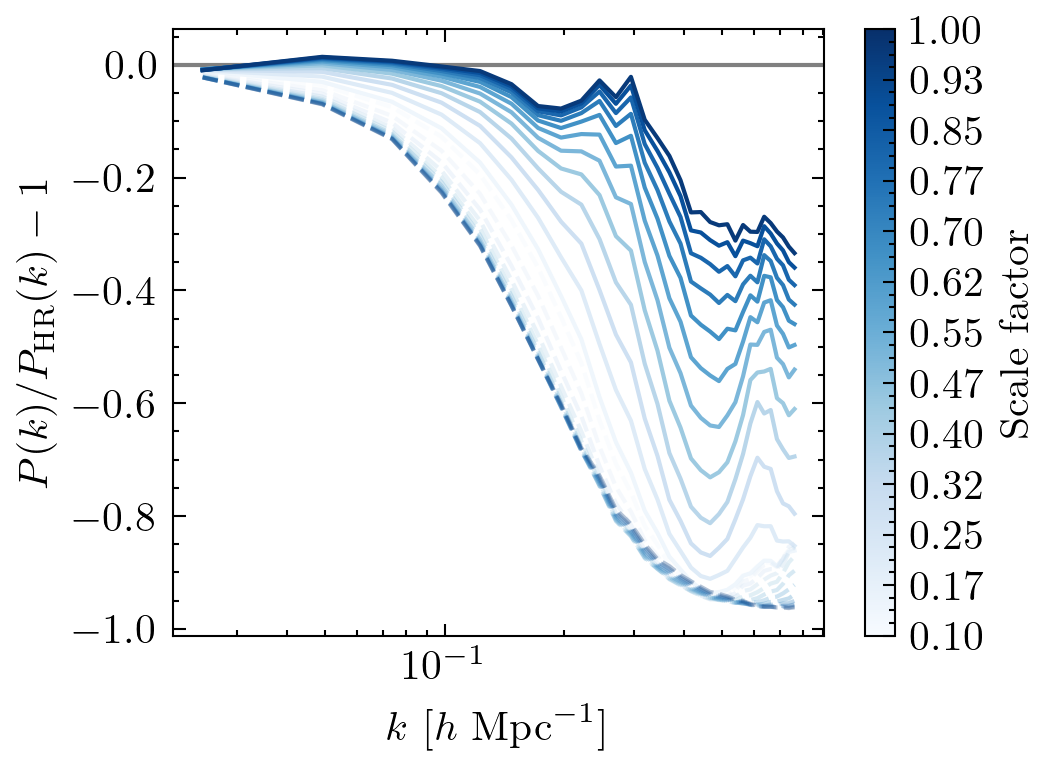

In [90]:
fig, ax = plt.subplots()

ax.axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax.semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax.semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax.set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")


/n/home11/ccuestalazaro/tmp/ipykernel_3910582/3212204088.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


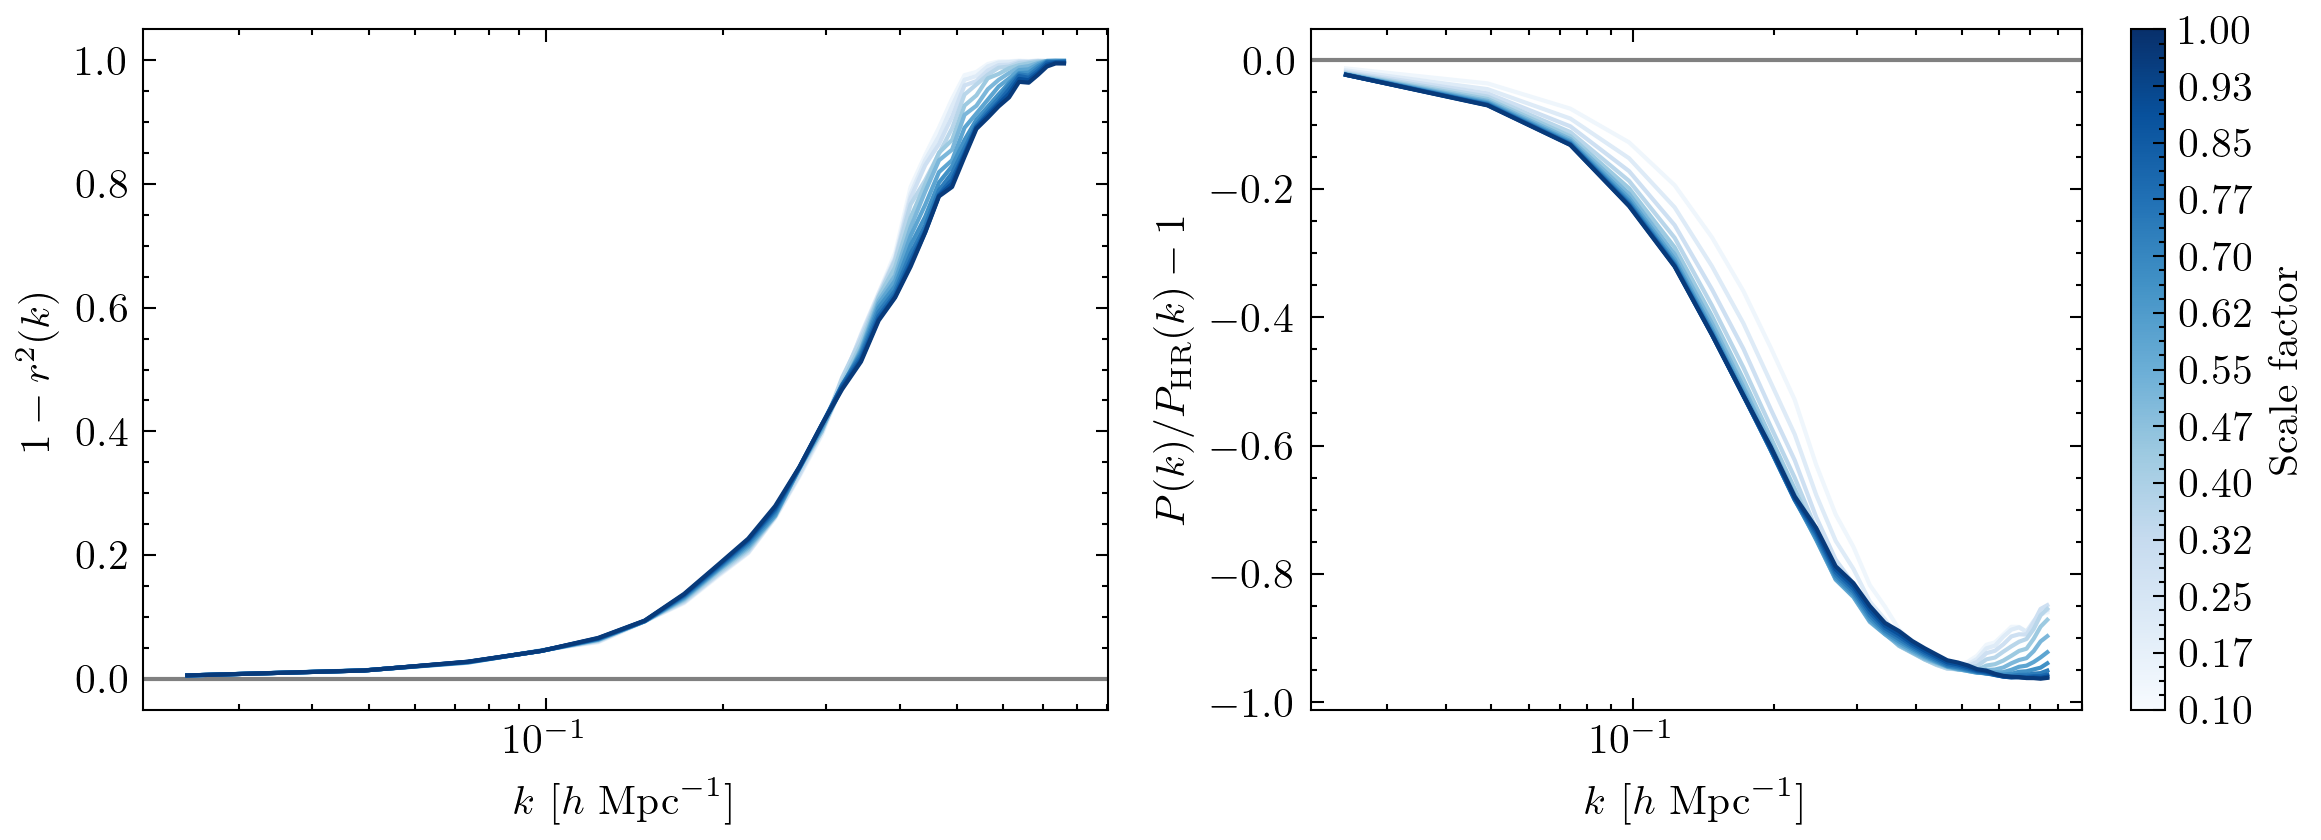

In [91]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] -1., color=color)
        c = ax[0].semilogx(k, 1.-r_lrs_sq[i], color=color)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()

/n/home11/ccuestalazaro/tmp/ipykernel_3910582/2383844706.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


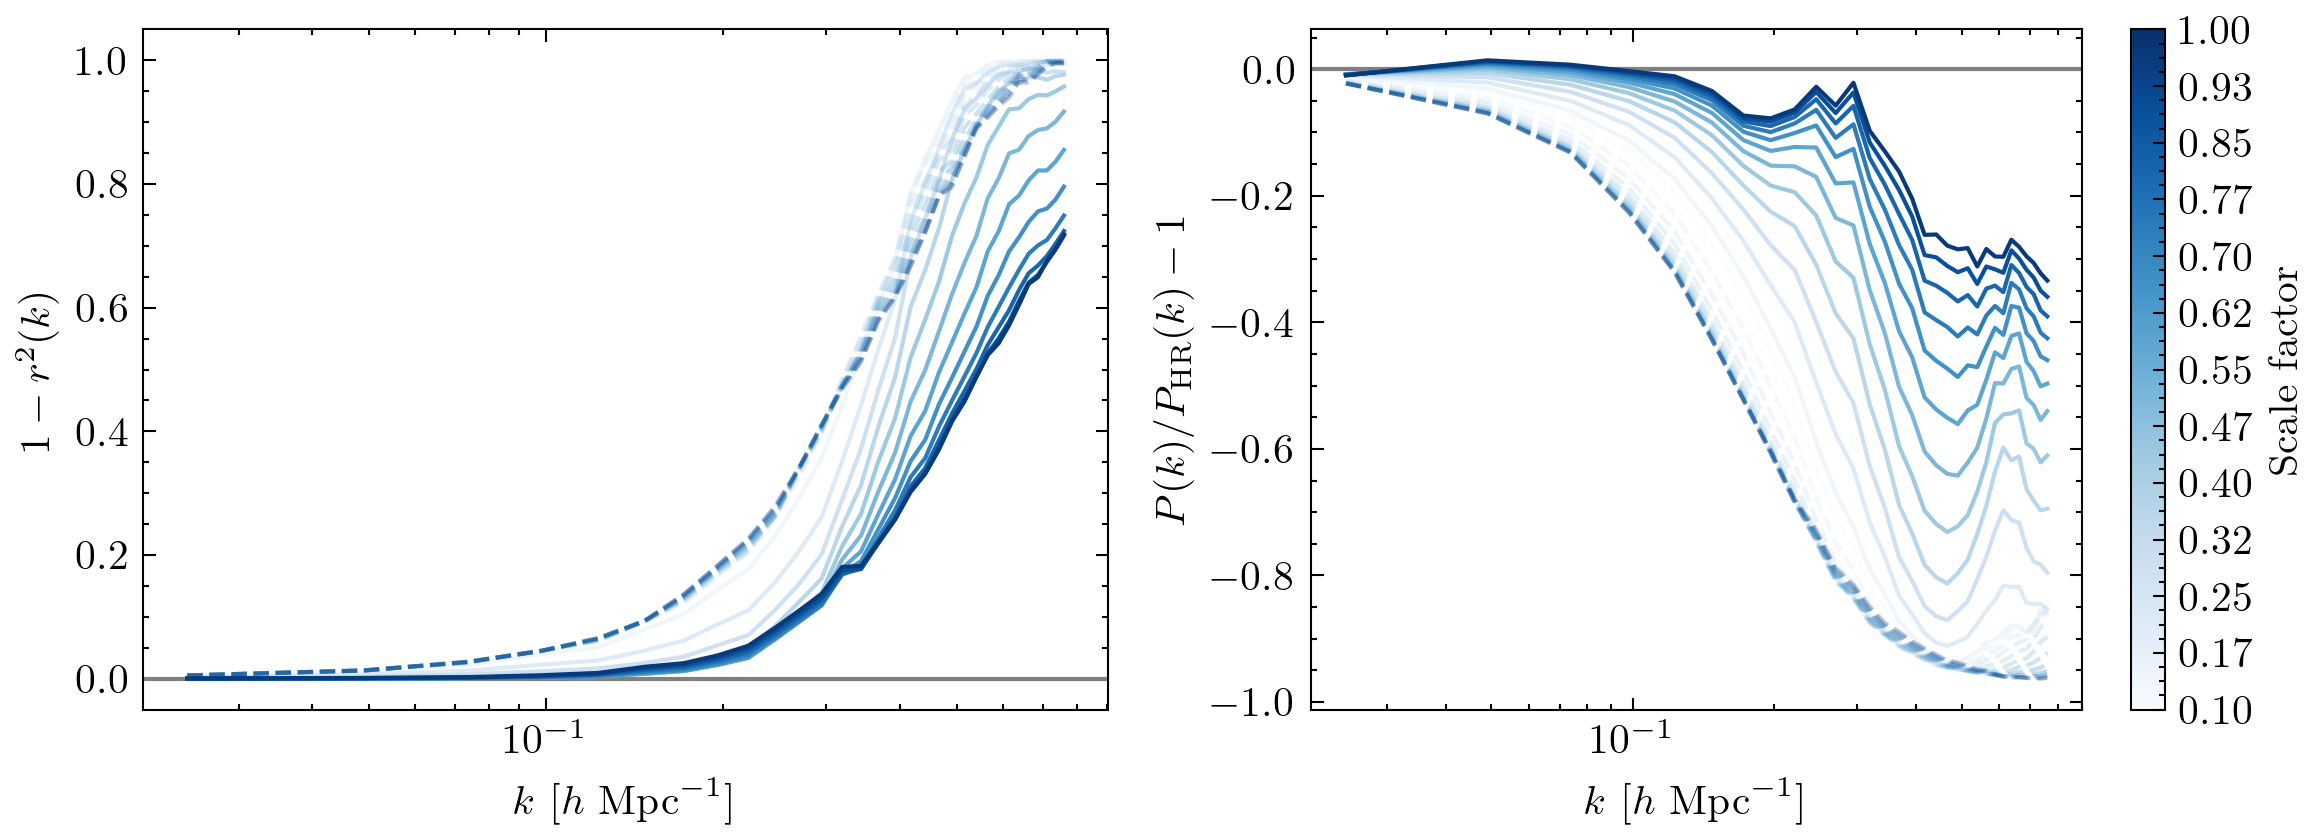

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
        c = ax[0].semilogx(k, 1.-r_preds_sq[i], color=color)
        ax[0].semilogx(k, 1.-r_lrs_sq[i], color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()
plt.savefig('figures/png/redshit_evolution.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/redshift_evolution.pdf', bbox_inches="tight")

In [93]:
# Get gravatational potentials and overdensities (at redshift 0)
from loss import get_gravitational_potential

In [94]:
_, pot_hr = get_gravitational_potential(data['hr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)
_, pot_lr = get_gravitational_potential(data['lr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)

In [95]:

_, pot_pred = get_gravitational_potential(pos_pred[-1]*mesh_hr, n_mesh=mesh_hr)

In [96]:
from jaxpm.painting import cic_paint, cic_read
from scipy.stats import binned_statistic


In [97]:
# read overdensity values at position
dens_hr = cic_read(delta_hr, data['hr'].positions[-1]*mesh_hr)

In [98]:
# correction:
pot_corr = pot_pred - pot_lr

In [99]:
density_bins = np.linspace(np.min(dens_hr), 40., 80)
bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_corr, statistic='mean', bins=density_bins)
lr_bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_lr, statistic='mean', bins=density_bins)


Text(0.5, 0, '$\\delta$')

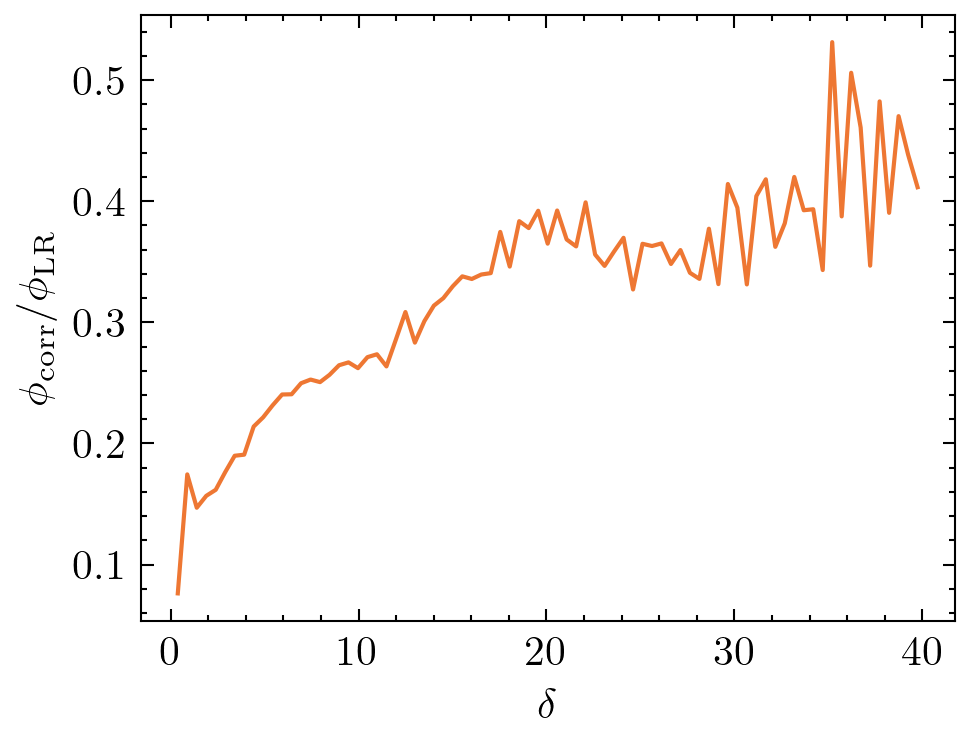

In [100]:
plt.plot( (bin_edges[1:] + bin_edges[:-1])/2., bin_means/lr_bin_means)
plt.ylabel(r'$\phi_\mathrm{corr}/\phi_\mathrm{LR}$')
plt.xlabel(r'$\delta$')

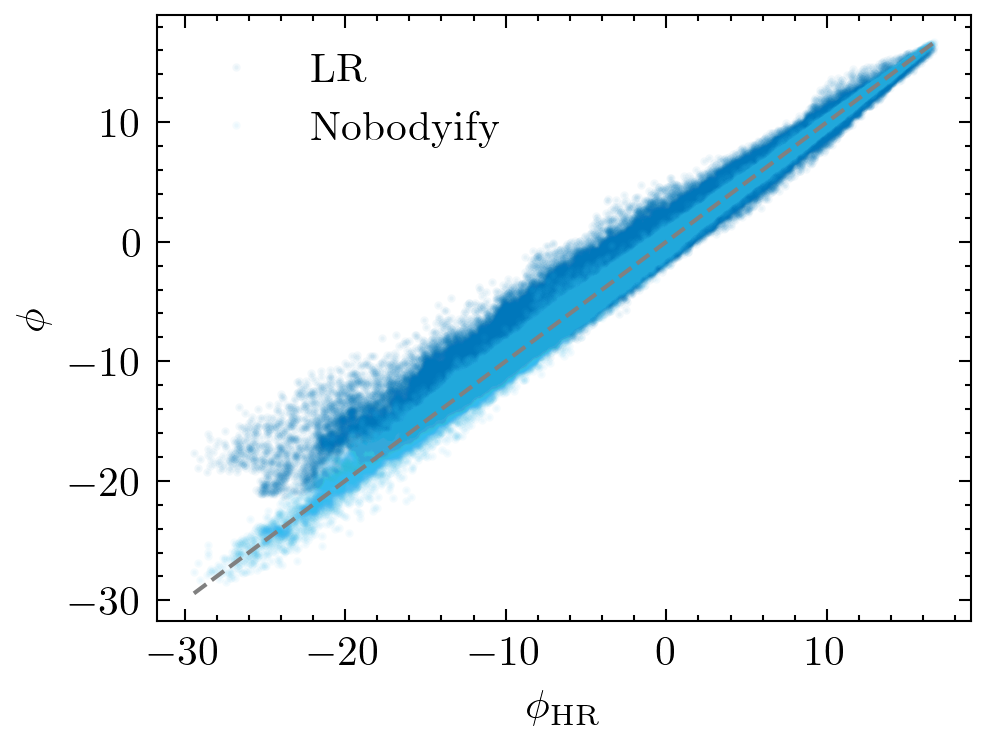

In [101]:
plt.plot(
    pot_hr,
    pot_lr,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='LR',
    color=c_lr[0].get_color(),
)
plt.plot(
    pot_hr,
    pot_pred,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='Nobodyify',
    color=c_pred[0].get_color(),
)
plt.plot(
    [np.min(pot_hr), np.max(pot_hr)],
    [np.min(pot_hr), np.max(pot_hr)],
    color='gray',
    linestyle='dashed',
)
plt.xlabel(r'$\phi_\mathrm{HR}$')
plt.ylabel(r'$\phi$')
plt.legend()
